In [1]:
!pip install pandas
!pip install seaborn
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 28.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 31.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 30.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 25.2 MB/s eta 0:00:00


In [61]:
import pandas as pd
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression

# Case I - Cancelamentos de Reserva

Construir dois modelos para prever o cancelamento de reservas:

- O primeiro é para um cliente que vive uma realidade de dados muito rudimentar. Logo, o modelo precisa ser simples, de forma a aprofundar o entendimento do cliente sobre o fenômeno modelado.
- O segundo é para um cliente que tem uma infrasetrutura de dados extremamente desenvolvida. O modelo será utilizado para fazer previsões no momento de cada reserva, estimando a probabilidade de cancelamento desta.

https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [2]:
tb_hotel = pd.read_csv('data/tb_hotel_traintest.csv')
tb_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113409 entries, 0 to 113408
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           113409 non-null  object 
 1   is_cancelled                    113409 non-null  int64  
 2   lead_time                       113409 non-null  int64  
 3   stays_in_weekend_nights         113409 non-null  int64  
 4   stays_in_week_nights            113409 non-null  int64  
 5   adults                          113409 non-null  int64  
 6   children                        113406 non-null  float64
 7   babies                          113409 non-null  int64  
 8   meal                            113409 non-null  object 
 9   country                         112951 non-null  object 
 10  market_segment                  113409 non-null  object 
 11  distribution_channel            113409 non-null  object 
 12  is_repeated_gues

## Exercício I

A primeira etapa na construção de um modelo é a etapa de formulação de hipóteses a respeito do fenômeno que queremos modelar. Embora o avanço da disponibilidade de capacidade computacional e de dados coletados nos permita adotar uma metodologia que parte de uma exploração direta do dataset, neste exercicio buscaremos trabalhar a formulação de hipóteses independente dos dados.

O objetivo é formular hipóteses sobre os fatores e mecânismos que aumentam ou diminuem a probabilidade de uma reserva ser cancelada. Podemos utilizar uma metodologia como os 5-Porques (https://en.wikipedia.org/wiki/Five_whys) para facilitar e nos guiar nesse processo, mas esse é um exercício de devaneio e imaginação!!

**As respostas estão no .txt "case I - analise de hipoteses"**

## Visualizando os dados

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

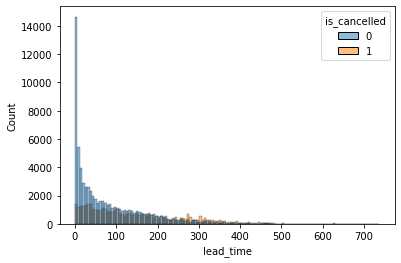

In [3]:
sns.histplot(data=tb_hotel, x='lead_time', hue='is_cancelled')

Histogramas não são bons de visualizar dados desbalanceados, a visão é mais focada no comportamento individual da variável. Melhor usar um boxplot pois a visão é do ponto de vista dos quartis, ou seja, temos uma visão do comportamento do agrupamento das variáveis, assim o gráfico além de fornecer mais informações, não fica poluido e confuso.

<AxesSubplot:xlabel='is_cancelled', ylabel='lead_time'>

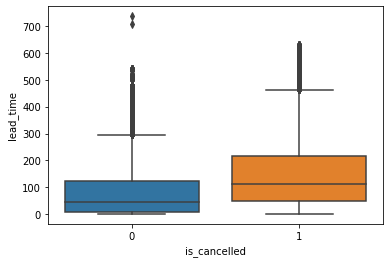

In [4]:
sns.boxplot(data=tb_hotel, y='lead_time', x='is_cancelled') # Melhor de visualizar classes desbalanceadas.

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

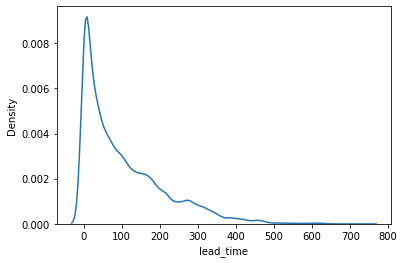

In [5]:
sns.kdeplot(data=tb_hotel, x='lead_time')

## Analisando o impacto do Lead Time nos cancelamentos usando Regressão Logística 

In [6]:
model = LogisticRegression()
model.fit(tb_hotel[['lead_time']], tb_hotel['is_cancelled'])
tb_hotel['pred_lead_time'] = model.predict_proba(tb_hotel[['lead_time']])[:,1]

In [7]:
model.predict_proba(tb_hotel[['lead_time']])[:,1]

array([0.69842564, 0.95917118, 0.24506141, ..., 0.27552691, 0.37125247,
       0.50905894])

<AxesSubplot:xlabel='lead_time', ylabel='pred_lead_time'>

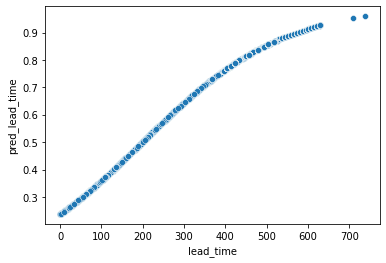

In [8]:
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_lead_time')

Observamos que de fato a chance de cancelamentos cresce à medida que o Lead Time aumenta. **Mas atenção às bordas da curva:** Na borda inferior por exemplo, por que temos cancelamentos em Lead Time = 0? É erro do modelo? Esses dados existem no Dataset? Vamos analisar:

#### Primeiro verificando no Dataset se existem variáveis onde há cancelamentos em Lead Time = 0

In [9]:
cancelamentos_na_hora = tb_hotel.loc[(tb_hotel['lead_time'] == 0) & (tb_hotel['is_cancelled'] == 1)]

In [10]:
tb_hotel.loc[(tb_hotel['lead_time'] == 0) & (tb_hotel['is_cancelled'] == 0)].shape # 5596 não cancelamentos na hora. 

(5596, 30)

In [11]:
cancelamentos_na_hora # 401 Cancelamentos na hora.

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,id_booking,pred_lead_time
418,Resort Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,123.2,0,0,2015-07-16,2015-07-16,438,0.237545
481,Resort Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,136.0,0,0,2015-07-17,2015-07-17,504,0.237545
763,Resort Hotel,1,0,0,1,1,0.0,0,BB,PRT,...,270.0,0,Transient,114.0,0,0,2015-07-30,2015-07-30,796,0.237545
872,Resort Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,172.0,0,1,2015-08-05,2015-08-05,909,0.237545
1596,Resort Hotel,1,0,0,1,1,0.0,0,BB,PRT,...,NaN,0,Transient,146.0,0,2,2015-09-09,2015-09-09,1673,0.237545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93851,City Hotel,1,0,1,0,2,0.0,0,BB,PRT,...,NaN,0,Transient,77.0,0,2,2016-12-12,2016-12-12,98809,0.237545
93852,City Hotel,1,0,1,0,2,0.0,0,BB,PRT,...,NaN,0,Transient,0.0,0,2,2016-12-12,2016-12-12,98810,0.237545
96819,City Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,0.0,0,0,2017-06-29,2017-06-29,101930,0.237545
100598,City Hotel,1,0,0,1,1,0.0,0,BB,PRT,...,45.0,0,Transient,0.0,0,2,2017-04-18,2017-04-18,105909,0.237545


In [12]:
cancelamentos_na_hora['country'].value_counts() # Obvio que a maioria seriam Portugueses

PRT    324
FRA     12
ESP      8
GBR      5
USA      4
AGO      4
DEU      4
BRA      3
BEL      3
CN       2
SWE      2
ITA      2
NLD      2
RUS      2
ECU      1
ZAF      1
AZE      1
BLR      1
AUT      1
SVK      1
MAR      1
POL      1
IRL      1
ROU      1
KOR      1
Name: country, dtype: int64

In [13]:
cancelamentos_na_hora['company'].isna().sum() # Reservas não coorporativas

347

### Aqui observamos a existência de reservas com 0 adultos, crianças e bebês. O que podem ser dados inválidos.

In [14]:
cancelamentos_na_hora[['adults', 'children', 'babies']].value_counts() / cancelamentos_na_hora.shape[0]

adults  children  babies
2       0.0       0         0.603491
1       0.0       0         0.294264
0       0.0       0         0.029925
3       0.0       0         0.024938
2       1.0       0         0.019950
        2.0       0         0.012469
3       1.0       0         0.007481
2       2.0       1         0.004988
        0.0       1         0.002494
dtype: float64

In [15]:
tb_hotel[['adults', 'children', 'babies']].value_counts() / tb_hotel.shape[0]

adults  children  babies
2       0.0       0         0.683138
1       0.0       0         0.188618
3       0.0       0         0.047606
2       1.0       0         0.033322
        2.0       0         0.026938
        0.0       1         0.005917
3       1.0       0         0.004127
1       1.0       0         0.002310
0       2.0       0         0.001764
        0.0       0         0.001473
1       2.0       0         0.001287
2       1.0       1         0.001146
4       0.0       0         0.000520
2       3.0       0         0.000503
3       2.0       0         0.000335
2       2.0       1         0.000238
        0.0       2         0.000106
0       3.0       0         0.000097
3       0.0       1         0.000079
1       0.0       1         0.000079
26      0.0       0         0.000044
1       3.0       0         0.000035
0       1.0       0         0.000035
2       1.0       2         0.000026
0       2.0       1         0.000026
20      0.0       0         0.000018
27      0.0  

<AxesSubplot:xlabel='deposit_type', ylabel='Count'>

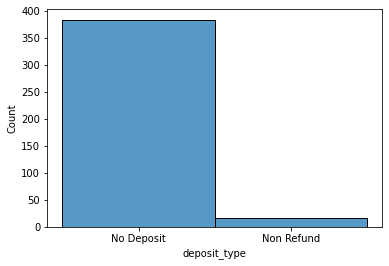

In [16]:
cancelamentos_na_hora['deposit_type'].value_counts()
sns.histplot(data=cancelamentos_na_hora, x='deposit_type')

In [17]:
cancelamentos_na_hora['adr'].value_counts()

0.00      40
109.00    29
89.00     19
12.00     17
8.00      13
          ..
207.00     1
174.00     1
168.00     1
205.33     1
77.00      1
Name: adr, Length: 150, dtype: int64

### Atenção aqui:
Aqui o objetivo era analisar se nos cancelamentos em Lead Time = 0, o tipo de hotel tinha alguma relação. Nesses casos é importante analisar tanto a distribuição da subamostra em questão e comparar com a distribuição do Dataset completo para ver se há alguma diferença.

Nesse caso em particular, não teve :P. Be Careful!

<AxesSubplot:xlabel='hotel', ylabel='Count'>

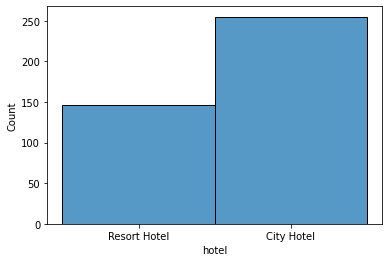

In [18]:
cancelamentos_na_hora['hotel'].value_counts()
sns.histplot(data=cancelamentos_na_hora, x='hotel')

<AxesSubplot:xlabel='hotel', ylabel='Count'>

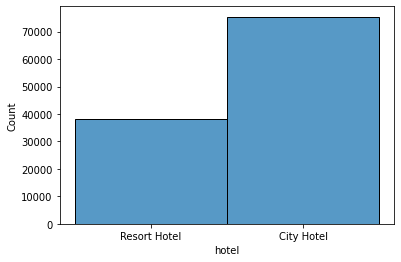

In [19]:
sns.histplot(data=tb_hotel, x='hotel')

/tmp/ipykernel_400/818762392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelamentos_na_hora['stays_total'] = cancelamentos_na_hora['stays_in_weekend_nights'] + cancelamentos_na_hora['stays_in_week_nights']


<AxesSubplot:xlabel='stays_total', ylabel='Count'>

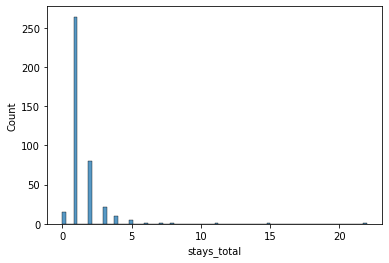

In [20]:
cancelamentos_na_hora['stays_total'] = cancelamentos_na_hora['stays_in_weekend_nights'] + cancelamentos_na_hora['stays_in_week_nights']
cancelamentos_na_hora['stays_total'].value_counts()
sns.histplot(data=cancelamentos_na_hora, x='stays_total')

<AxesSubplot:xlabel='stays_total', ylabel='Count'>

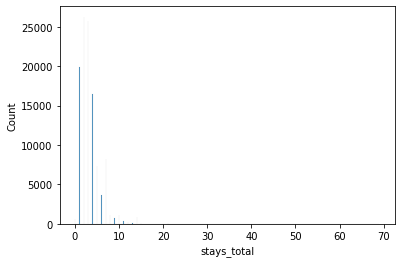

In [21]:
tb_hotel['stays_total'] = tb_hotel['stays_in_weekend_nights'] + tb_hotel['stays_in_week_nights']
tb_hotel['stays_total'].value_counts()
sns.histplot(data=tb_hotel, x='stays_total')

In [22]:
cancelamentos_fantasmas = cancelamentos_na_hora.loc[(cancelamentos_na_hora['adults'] == 0) & (cancelamentos_na_hora['children'] == 0.0) & (cancelamentos_na_hora['babies'] == 0)]

In [23]:
cancelamentos_fantasmas

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,id_booking,pred_lead_time,stays_total
3923,Resort Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-02-15,2016-02-15,4127,0.237545,0
57608,City Hotel,1,0,4,11,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-11-17,2016-11-17,60651,0.237545,15
58167,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-12-06,2016-12-06,61244,0.237545,0
58168,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-12-06,2016-12-06,61245,0.237545,0
58172,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-12-06,2016-12-06,61249,0.237545,0
61537,City Hotel,1,0,0,3,0,0.0,0,BB,PRT,...,0,Transient,0.0,0,0,2017-03-16,2017-03-16,64782,0.237545,3
62601,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65907,0.237545,0
62602,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65908,0.237545,0
62603,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65909,0.237545,0
62604,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65910,0.237545,0


# Analisando a Borda Superior da predição

In [24]:
lead_time_longo = tb_hotel.loc[(tb_hotel['lead_time'] == 0) & (tb_hotel['is_cancelled'] == 1)]

**Uso do pd.qcut:** Útil para <i>discretizar</i> dados de uma coluna, isto é, agrupa os dados em intervalos fixos (quantis) onde nós determinamos essa quantidade de grupos. Nisso temos uma coluna de valores inteiros ou categóricos (discretos) baseado numa coluna de valores contínuos.

In [25]:
tb_hotel['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], 10, labels=[str(i) for i in range(1, 11)]) # Aqui nós criamos a coluna cat_lead_time com a discretização de lead_time.

In [26]:
tb_hotel['cat_lead_time']

0         10
1         10
2          2
3          3
4          3
          ..
113404     3
113405     7
113406     4
113407     7
113408     9
Name: cat_lead_time, Length: 113409, dtype: category
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']

In [27]:
a_ratio = tb_hotel.loc[(tb_hotel['cat_lead_time'] == '1') & (tb_hotel['is_cancelled'] == 1)].shape[0] / tb_hotel['is_cancelled'].shape[0]

In [28]:
a_ratio

0.009549506652911145

In [29]:
tb_hotel.groupby('cat_lead_time')['is_cancelled'].mean()

cat_lead_time
1     0.083500
2     0.159411
3     0.285714
4     0.358924
5     0.383482
6     0.407999
7     0.432777
8     0.466201
9     0.474881
10    0.673058
Name: is_cancelled, dtype: float64

In [30]:
is_canc_comparison = tb_hotel.groupby('cat_lead_time')[['is_cancelled', 'pred_lead_time']].mean().reset_index()

In [31]:
is_canc_comparison['diff_pred'] = is_canc_comparison['is_cancelled'] - is_canc_comparison['pred_lead_time']

### Dever de casa:

Adicionar à is_canc_comparison uma coluna com as predições do modelo por categoria (tb_cat[pred_lead_time_cat]). Analisar o diff_pred em relação ao resutado desses dois modelos e observar os ganhos dos grupos, se foram muito significativos ou não.

### Abaixo temos uma tabela onde:
Os dados estão segmentados em 10 categorias e relacionamos os scores de cancelamentos observados (is_cancelled) com os cancelamentos predizidos pelo modelo treinado sem segmentação de categorias (pred_is_canceled).

Calculamos a diferença entre eles (diff_pred) para visualizar os ganhos.

In [32]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_lead_time,diff_pred
0,1,0.083500,0.238562,-0.155062
1,2,0.159411,0.245133,-0.085722
2,3,0.285714,0.258172,0.027542
3,4,0.358924,0.277895,0.081029
4,5,0.383482,0.303787,0.079695
5,6,0.407999,0.338578,0.069420
6,7,0.432777,0.384374,0.048403
7,8,0.466201,0.445024,0.021176
8,9,0.474881,0.531382,-0.056501
9,10,0.673058,0.691394,-0.018336


## Treinando a Regressão Logística para as categorias que criamos

In [33]:
tb_hotel2 = pd.DataFrame()

In [34]:
for cat in tb_hotel['cat_lead_time'].unique():
    tb_cat = tb_hotel[tb_hotel['cat_lead_time'] == cat].copy()
    model3 = LogisticRegression()
    model3.fit(tb_cat[['lead_time']], tb_cat['is_cancelled'])
    tb_cat['pred_lead_time_cat'] = model3.predict_proba(tb_cat[['lead_time']])[:,1]
    tb_hotel2 = pd.concat((tb_hotel2, tb_cat), axis=0)

In [35]:
tb_hotel2 # Tabela com o resultado da Regressão por categoria

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,id_booking,pred_lead_time,stays_total,cat_lead_time,pred_lead_time_cat
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,0.00,0,0,2015-07-01,2015-07-01,0,0.698426,0,10,0.672943
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,0.00,0,0,2015-07-01,2015-07-01,1,0.959171,0,10,0.825615
80,Resort Hotel,1,368,3,7,2,0.0,0,BB,PRT,...,55.68,0,0,2015-05-19,2015-07-03,81,0.729545,10,10,0.684899
81,Resort Hotel,0,364,3,7,2,0.0,0,BB,GBR,...,55.68,0,0,2015-07-13,2015-07-03,82,0.724891,10,10,0.683075
84,Resort Hotel,0,324,4,10,2,0.0,0,HB,GBR,...,134.73,0,0,2015-07-17,2015-07-03,85,0.675734,14,10,0.664531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113366,City Hotel,0,149,0,4,2,0.0,0,BB,ESP,...,84.60,0,0,2017-09-03,2017-08-30,119343,0.427459,4,8,0.469902
113391,City Hotel,0,175,1,3,2,0.0,0,BB,NLD,...,86.85,0,2,2017-09-04,2017-08-31,119371,0.465125,4,8,0.464666
113392,City Hotel,0,175,1,3,1,0.0,0,BB,NLD,...,82.35,0,1,2017-09-04,2017-08-31,119372,0.465125,4,8,0.464666
113395,City Hotel,0,165,1,5,3,0.0,0,BB,AUT,...,209.25,0,3,2017-09-04,2017-08-29,119376,0.450567,6,8,0.466679


<AxesSubplot:xlabel='lead_time', ylabel='pred_lead_time'>

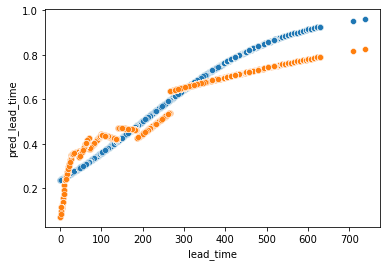

In [36]:
sns.scatterplot(data=tb_hotel2, x='lead_time', y='pred_lead_time')
sns.scatterplot(data=tb_hotel2, x='lead_time', y='pred_lead_time_cat')

In [37]:
results_cat = tb_hotel2.groupby('cat_lead_time')['pred_lead_time_cat'].mean().reset_index()
results_cat

,cat_lead_time,pred_lead_time_cat
0,1,0.083500
1,2,0.159411
2,3,0.285714
3,4,0.358924
4,5,0.383483
5,6,0.407998
6,7,0.431087
7,8,0.467461
8,9,0.474881
9,10,0.672253


In [38]:
is_canc_comparison['pred_is_canceled_cat'] = results_cat['pred_lead_time_cat'].values

In [39]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_lead_time,diff_pred,pred_is_canceled_cat
0,1,0.083500,0.238562,-0.155062,0.083500
1,2,0.159411,0.245133,-0.085722,0.159411
2,3,0.285714,0.258172,0.027542,0.285714
3,4,0.358924,0.277895,0.081029,0.358924
4,5,0.383482,0.303787,0.079695,0.383483
5,6,0.407999,0.338578,0.069420,0.407998
6,7,0.432777,0.384374,0.048403,0.431087
7,8,0.466201,0.445024,0.021176,0.467461
8,9,0.474881,0.531382,-0.056501,0.474881
9,10,0.673058,0.691394,-0.018336,0.672253


In [40]:
is_canc_comparison['diff_pred_cat'] = is_canc_comparison['is_cancelled'] - is_canc_comparison['pred_is_canceled_cat']

### Resultados de q=10:
- Será que isso tá certo? Por que na tabela a diferença de valores é tão pequena mas no plot conseguimos ver uma diferença gritante nesse score de cancelamento?

In [41]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_lead_time,diff_pred,pred_is_canceled_cat,diff_pred_cat
0,1,0.083500,0.238562,-0.155062,0.083500,-9.585790e-09
1,2,0.159411,0.245133,-0.085722,0.159411,-7.037117e-09
2,3,0.285714,0.258172,0.027542,0.285714,3.002080e-07
3,4,0.358924,0.277895,0.081029,0.358924,3.547036e-09
4,5,0.383482,0.303787,0.079695,0.383483,-7.312493e-07
5,6,0.407999,0.338578,0.069420,0.407998,3.033470e-07
6,7,0.432777,0.384374,0.048403,0.431087,1.690215e-03
7,8,0.466201,0.445024,0.021176,0.467461,-1.260001e-03
8,9,0.474881,0.531382,-0.056501,0.474881,2.803198e-08
9,10,0.673058,0.691394,-0.018336,0.672253,8.046587e-04


In [42]:
q = 15
tb_hotel2['cat_lead_time'] = pd.qcut(tb_hotel2['lead_time'], q, labels=[str(i) for i in range(1, q+1)])
results7 = tb_hotel2.groupby('cat_lead_time')[['is_cancelled','pred_lead_time_cat']].mean().reset_index()

In [43]:
results7

,cat_lead_time,is_cancelled,pred_lead_time_cat
0,1,0.075317,0.074878
1,2,0.108869,0.109876
2,3,0.180621,0.180205
3,4,0.267829,0.265790
4,5,0.332266,0.340971
5,6,0.366649,0.360727
6,7,0.376159,0.368985
7,8,0.397639,0.398578
8,9,0.414097,0.420313
9,10,0.436682,0.434883


### Testando q=4

In [44]:
q = 4
tb_hotel['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], q, labels=[str(i) for i in range(1, q+1)]) 

In [45]:
is_canc_comparison_4 = tb_hotel.groupby('cat_lead_time')[['is_cancelled', 'pred_lead_time']].mean().reset_index()
is_canc_comparison_4['diff_pred'] = is_canc_comparison_4['is_cancelled'] - is_canc_comparison_4['pred_lead_time']
is_canc_comparison_4

,cat_lead_time,is_cancelled,pred_lead_time,diff_pred
0,1,0.145775,0.243963,-0.098188
1,2,0.358993,0.284861,0.074131
2,3,0.427219,0.374811,0.052408
3,4,0.554407,0.581390,-0.026983


In [46]:
tb_hotel2 = pd.DataFrame()
for cat in tb_hotel['cat_lead_time'].unique():
    tb_cat = tb_hotel[tb_hotel['cat_lead_time'] == cat].copy()
    model3 = LogisticRegression()
    model3.fit(tb_cat[['lead_time']], tb_cat['is_cancelled'])
    tb_cat['pred_lead_time_cat'] = model3.predict_proba(tb_cat[['lead_time']])[:,1]
    tb_hotel2 = pd.concat((tb_hotel2, tb_cat), axis=0)

<AxesSubplot:xlabel='lead_time', ylabel='pred_lead_time'>

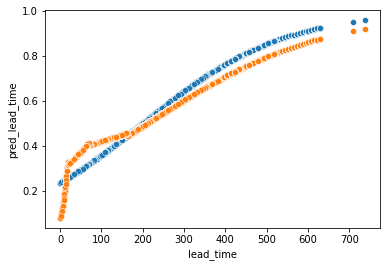

In [47]:
sns.scatterplot(data=tb_hotel2, x='lead_time', y='pred_lead_time')
sns.scatterplot(data=tb_hotel2, x='lead_time', y='pred_lead_time_cat')

In [48]:
q = 4
tb_hotel['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], q, labels=[str(i) for i in range(1, q+1)]) 
results4 = tb_hotel2.groupby('cat_lead_time')['pred_lead_time_cat'].mean().reset_index()

In [49]:
is_canc_comparison_4['pred_lead_time_cat'] = results4['pred_lead_time_cat']

In [50]:
is_canc_comparison_4

,cat_lead_time,is_cancelled,pred_lead_time,diff_pred,pred_lead_time_cat
0,1,0.145775,0.243963,-0.098188,0.145775
1,2,0.358993,0.284861,0.074131,0.358994
2,3,0.427219,0.374811,0.052408,0.427218
3,4,0.554407,0.581390,-0.026983,0.554407


In [51]:
tb_hotel2['pred_lead_time'].mean()

0.37065841335074273

In [52]:
tb_hotel2['is_cancelled'].mean()

0.3706584133534376

In [53]:
import numpy as np

In [54]:
q = 70
tb_hotel2['cat_lead_time'] = pd.cut(tb_hotel2['lead_time'], q)
results7 = tb_hotel2.groupby('cat_lead_time')[['is_cancelled', 'pred_lead_time','pred_lead_time_cat']].mean().reset_index()
results7['pred_diff'] = np.abs(results7['is_cancelled'] - results7['pred_lead_time'])
results7

,cat_lead_time,is_cancelled,pred_lead_time,pred_lead_time_cat,pred_diff
0,"(-0.737, 10.529]",0.111798,0.241000,0.109233,0.129202
1,"(10.529, 21.057]",0.260998,0.254579,0.272412,0.006419
2,"(21.057, 31.586]",0.332004,0.266901,0.329646,0.065103
3,"(31.586, 42.114]",0.363106,0.278785,0.349086,0.084320
4,"(42.114, 52.643]",0.357203,0.291338,0.369613,0.065864
...,...,...,...,...,...
65,"(684.357, 694.886]",NaN,NaN,NaN,NaN
66,"(694.886, 705.414]",NaN,NaN,NaN,NaN
67,"(705.414, 715.943]",0.000000,0.952232,0.912530,0.952232
68,"(715.943, 726.471]",NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='pred_diff'>

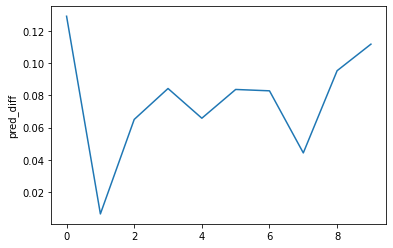

In [55]:
sns.lineplot(data=results7.iloc[:10,:], x=results7.iloc[:10,:].index, y='pred_diff')

# Tarefinha de casa
- Criar um algoritmo para encontrar um ponto P que divida o lead time em duas partes e que eu possa facilmente "reencontrá-lo" ao lidar com um novo dataset.
- Explicar qualitativamente por que existe um comportamento quando LT < P e outro totalmente diferente quando LT > P
- Construir a regressão usando L1 e L2 e plotar 

# Encontrando o ponto P

Pela abordagem da diferença entre as categorias de diff_preds médios.

In [56]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_lead_time,diff_pred,pred_is_canceled_cat,diff_pred_cat
0,1,0.083500,0.238562,-0.155062,0.083500,-9.585790e-09
1,2,0.159411,0.245133,-0.085722,0.159411,-7.037117e-09
2,3,0.285714,0.258172,0.027542,0.285714,3.002080e-07
3,4,0.358924,0.277895,0.081029,0.358924,3.547036e-09
4,5,0.383482,0.303787,0.079695,0.383483,-7.312493e-07
5,6,0.407999,0.338578,0.069420,0.407998,3.033470e-07
6,7,0.432777,0.384374,0.048403,0.431087,1.690215e-03
7,8,0.466201,0.445024,0.021176,0.467461,-1.260001e-03
8,9,0.474881,0.531382,-0.056501,0.474881,2.803198e-08
9,10,0.673058,0.691394,-0.018336,0.672253,8.046587e-04


<AxesSubplot:ylabel='is_cancelled'>

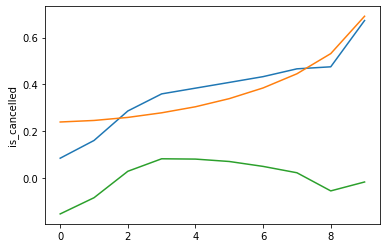

In [78]:
sns.lineplot(data=is_canc_comparison, x=is_canc_comparison.index, y=is_canc_comparison['is_cancelled']) # Azul
sns.lineplot(data=is_canc_comparison, x=is_canc_comparison.index, y=is_canc_comparison['pred_lead_time']) # Laranja
sns.lineplot(data=is_canc_comparison, x=is_canc_comparison.index, y=is_canc_comparison['diff_pred']) # Verde
    

In [75]:

# Diferença entre as categorias de is_cancelled
mean_canc = is_canc_comparison['is_cancelled']
lmc = len(mean_canc)
diffs = []
for cat in range(0, lmc):
    if cat + 1 < lmc:
        diffs.append(abs(mean_canc[cat] - mean_canc[cat+1]))
        print(f"cat{cat+1} - cat{cat+2} {abs(mean_canc[cat] - mean_canc[cat+1])}")

print(f"\n{sorted(diffs)[::-1]}") # Ordenando decrescente as diferenças entre os cancelamentos médios


cat1 - cat2 0.07591095544384097
cat2 - cat3 0.12630294476543316
cat3 - cat4 0.07320948110185782
cat4 - cat5 0.02455865841201227
cat5 - cat6 0.024516186726385725
cat6 - cat7 0.02477826831829999
cat7 - cat8 0.03342379217451297
cat8 - cat9 0.008680760891834005
cat9 - cat10 0.1981766242725122

[0.1981766242725122, 0.12630294476543316, 0.07591095544384097, 0.07320948110185782, 0.03342379217451297, 0.02477826831829999, 0.02455865841201227, 0.024516186726385725, 0.008680760891834005]


A maior diferença entre as médias de cancelamentos é entre as ultimas categorias(9 - 10), porém não iremos considerar pois sabemos que a média foi influenciada por outliers.

A segunda maior diferença entre as médias, é a da categoria 1 com a 2, parece mais confiável.

In [82]:

# Diferença entre as categorias de diff_pred
mean_canc = is_canc_comparison['diff_pred']
lmc = len(mean_canc)
diffs = []
for cat in range(0, lmc):
    if cat + 1 < lmc:
        diffs.append(abs(abs(mean_canc[cat]) - abs(mean_canc[cat+1])))
        print(f"cat{cat+1} - cat{cat+2} {abs(abs(mean_canc[cat]) - abs(mean_canc[cat+1]))}")

print(f"\n{sorted(diffs)[::-1]}") # Ordenando decrescente as diferenças entre os diff_preds médios

cat1 - cat2 0.06933965513329854
cat2 - cat3 0.05817961626683943
cat3 - cat4 0.053486741346880806
cat4 - cat5 0.0013341392637548632
cat5 - cat6 0.010274769081629886
cat6 - cat7 0.021017106657221785
cat7 - cat8 0.02722678030357617
cat8 - cat9 0.035324571331792454
cat9 - cat10 0.03816515129301551

[0.06933965513329854, 0.05817961626683943, 0.053486741346880806, 0.03816515129301551, 0.035324571331792454, 0.02722678030357617, 0.021017106657221785, 0.010274769081629886, 0.0013341392637548632]


Tratando a coluna como uma distribuição e analisando o desvio padrão

In [84]:
amostra = is_canc_comparison['diff_pred']
std_amostra = np.std(amostra)
diffs = []

for i in range(0, len(amostra)):
    diffs.append(abs(amostra[i]-std_amostra))
    print(f"cat {i}: {abs(amostra[i]-std_amostra)}")

print(max(diffs))

cat -0.15506172920645384: 0.23002406596662942
cat -0.0857220740731553: 0.16068441083333088
cat 0.027542457806315868: 0.04741987895385971
cat 0.08102919915319667: 0.006066862393021094
cat 0.07969505988944181: 0.004732723129266231
cat 0.06942029080781192: 0.005542045952363656
cat 0.04840318415059014: 0.02655915260958544
cat 0.02117640384701397: 0.05378593291316161
cat -0.05650097517880642: 0.131463311938982
cat -0.018335823885790914: 0.0932981606459665
0.23002406596662942
